In [4]:
import os, random, math, sys, time 

#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import torch.utils.data
import torchvision

from pycocotools import mask as coco_mask
import numpy as np
from typing import Iterable


from datasets.coco import CocoDetection
import datasets.transforms as T
import util.misc as utils
from datasets.coco_eval import CocoEvaluator
from models.sintwindetr import SinTwinDetr
from models.detr import PostProcess
from models.matcher import HungarianMatcher
from models.detr import SetCriterion


In [5]:
seed = 42
num_classes = 91
num_queries = 100
null_class_coef = 0.5
BATCH_SIZE = 8
LR = 2e-5
EPOCHS = 2

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(seed)

In [7]:
def make_coco_transforms(image_set):

    normalize = T.Compose([
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


    if image_set == 'train':
        return T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomSelect(
                T.Resize((224,224)), 
                T.Compose([
                    T.RandomResize([400, 500, 600]),
                    T.RandomSizeCrop(384, 600),
                    T.Resize((224,224)),
                ])
            ),
            normalize,
        ])

    if image_set == 'val':
        return T.Compose([
            T.Resize((224,224)),
            normalize,
        ])

    raise ValueError(f'unknown {image_set}')

In [8]:
img_folder_val = 'd:\\ThisSemester\\COCO\\val2017'
annotation_val = 'd:\\ThisSemester\\COCO\\annotations\\instances_val2017.json'


img_folder_train = 'd:\\ThisSemester\\COCO\\train2017'
annotation_train = 'd:\\ThisSemester\\COCO\\annotations\\instances_train2017.json'

mode_train = 'train'
mode_val = 'val'
return_masks = False

valdataset = CocoDetection(img_folder = img_folder_val, 
                           ann_file = annotation_val,
                           transforms = make_coco_transforms(mode_val),
                           return_masks = return_masks)

traindataset = CocoDetection(img_folder = img_folder_train, 
                             ann_file = annotation_train,
                             transforms = make_coco_transforms(mode_train),
                             return_masks = return_masks)

loading annotations into memory...
Done (t=1.04s)
creating index...
index created!
loading annotations into memory...
Done (t=27.83s)
creating index...
index created!


In [9]:
valdataset, traindataset

(Dataset CocoDetection
     Number of datapoints: 5000
     Root location: d:\ThisSemester\COCO\val2017,
 Dataset CocoDetection
     Number of datapoints: 118287
     Root location: d:\ThisSemester\COCO\train2017)

In [22]:
from util.misc import AverageMeter
def train_one_epoch(model: torch.nn.Module, criterion: torch.nn.Module,
                    data_loader, optimizer: torch.optim.Optimizer, 
                    scheduler: torch.optim, device: torch.device,
                    epoch: int, max_norm: float = 0):
    model.train()
    criterion.train()
    summary_loss = AverageMeter()
    header = 'Epoch: [{}]'.format(epoch)
    print(header)

    for step, (samples, targets) in enumerate(data_loader):
        
        samples =  samples[0].unsqueeze(0) #list(image.to(device) for image in samples)
        #samples = torchvision.transforms.Resize((224,224))(samples)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(samples)
        loss_dict = criterion(outputs, targets)
        weight_dict = criterion.weight_dict
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        loss_dict_reduced_unscaled = {f'{k}_unscaled': v
                                      for k, v in loss_dict_reduced.items()}
        loss_dict_reduced_scaled = {k: v * weight_dict[k]
                                    for k, v in loss_dict_reduced.items() if k in weight_dict}
        losses_reduced_scaled = sum(loss_dict_reduced_scaled.values())

        loss_value = losses_reduced_scaled.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)
            
        #loss_value = losses.item()
        
        
        
        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        if max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        summary_loss.update(loss_value, BATCH_SIZE)
    return summary_loss


@torch.no_grad()
def evaluate(model, criterion, data_loader, device):

    model.eval()
    criterion.eval()
    summary_loss = AverageMeter()

    header = 'Test:'
    
    coco = data_loader.dataset.coco
    iou_types = ["bbox"]
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for step, (samples, targets) in enumerate(data_loader):
        print(step)
        samples = samples[0].unsqueeze(0)
        #samples = torchvision.transforms.Resize((224,224))(samples)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(samples)
        loss_dict = criterion(outputs, targets)
        weight_dict = criterion.weight_dict

        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        
        loss_value = losses.item()
        
        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            sys.exit(1)

       

    summary_loss.update(losses.item(),BATCH_SIZE)
    return summary_loss


In [11]:
import util.utils
@torch.no_grad()
def _evaluate(model, data_loader, device):
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = 'Test:'

    coco = data_loader.dataset.coco
    iou_types = ["bbox"]
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for images, targets in metric_logger.log_every(data_loader, 100, header):
        images = images[0].unsqueeze(0).to(device)

    
        model_time = time.time()
        outputs = model(images)
        model_time = time.time() - model_time
        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return coco_evaluator

@torch.no_grad()
def evaluate(model, criterion, postprocessors, data_loader, device):
    model.eval()
    criterion.eval()

    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('class_error', utils.SmoothedValue(window_size=1, fmt='{value:.2f}'))
    header = 'Test:'

    iou_types = ['bbox']
    coco_evaluator = CocoEvaluator(data_loader.dataset.coco, iou_types)
    # coco_evaluator.coco_eval[iou_types[0]].params.iouThrs = [0, 0.1, 0.5, 0.75]

    for samples, targets in metric_logger.log_every(data_loader, 10, header):
        samples = samples[0].unsqueeze(0).to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(samples)
        loss_dict = criterion(outputs, targets)
        weight_dict = criterion.weight_dict

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        loss_dict_reduced_scaled = {k: v * weight_dict[k]
                                    for k, v in loss_dict_reduced.items() if k in weight_dict}
        loss_dict_reduced_unscaled = {f'{k}_unscaled': v
                                      for k, v in loss_dict_reduced.items()}
        metric_logger.update(loss=sum(loss_dict_reduced_scaled.values()),
                             **loss_dict_reduced_scaled,
                             **loss_dict_reduced_unscaled)
        metric_logger.update(class_error=loss_dict_reduced['class_error'])

        orig_target_sizes = torch.stack([t["orig_size"] for t in targets], dim=0)
        results = postprocessors['bbox'](outputs, orig_target_sizes)

        res = {target['image_id'].item(): output for target, output in zip(targets, results)}
        if coco_evaluator is not None:
            coco_evaluator.update(res)

        
    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    if coco_evaluator is not None:
        coco_evaluator.synchronize_between_processes()
   
    # accumulate predictions from all images
    if coco_evaluator is not None:
        coco_evaluator.accumulate()
        coco_evaluator.summarize()
    
    stats = {k: meter.global_avg for k, meter in metric_logger.meters.items()}
    if coco_evaluator is not None:
        if 'bbox' in postprocessors.keys():
            stats['coco_eval_bbox'] = coco_evaluator.coco_eval['bbox'].stats.tolist()
        if 'segm' in postprocessors.keys():
            stats['coco_eval_masks'] = coco_evaluator.coco_eval['segm'].stats.tolist()
    return stats, coco_evaluator


In [12]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [13]:
sampler_val = torch.utils.data.SequentialSampler(valdataset)
sampler_train = torch.utils.data.RandomSampler(traindataset)

In [14]:
trainloader = DataLoader(traindataset,
                        batch_size = 1,
                        sampler = sampler_train,
                        collate_fn=collate_fn,
                        drop_last=False)

valloader = DataLoader(valdataset,
                       batch_size=1,
                       sampler = sampler_val,
                       collate_fn=collate_fn,
                       drop_last=False)

In [15]:

num_classes = 91
device = torch.device('cpu')

net = SinTwinDetr(num_classes).to(device)

state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location='cpu',
    check_hash=True)

del state_dict['conv.weight']
net.load_state_dict(state_dict, strict = False)

matcher = HungarianMatcher()

weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}

losses = ['labels', 'boxes', 'cardinality']

In [16]:
criterion = SetCriterion(num_classes, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
criterion = criterion.to(device)

In [28]:
optimizer = torch.optim.AdamW(net.parameters(), lr= 1e-4)

In [30]:
x, y = next(iter(trainloader))

     
samples =  x[0].unsqueeze(0) #list(image.to(device) for image in samples)
targets = [{k: v.to(device) for k, v in t.items()} for t in y]

outputs = net(samples)


In [19]:
module_names = [name for name, module in net.named_modules()]
print(len(module_names))

717


In [31]:
postprocessors = {'bbox': PostProcess()}

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5)

In [32]:
epochs = 10
best_loss = 10**5

for epoch in range(epochs):
    
    train_stats = train_one_epoch(net, criterion, trainloader, optimizer, scheduler, device, epoch)
    #eval_stats = evaluate(net, criterion, valloader , device)
    eval_stats, coco_evaluator = evaluate(net, criterion, postprocessors, valloader, device)
    
    print('|EPOCH {}| TRAIN_LOSS {}| VALID_LOSS {}|'.format(epoch+1, train_stats.avg, eval_stats.avg))
    if eval_stats.avg < best_loss:
            best_loss = eval_stats.avg
            print('Best model found Epoch {}........Saving Model'.format(epoch+1))
            torch.save(net.state_dict(), f'net_best_{epoch}.pth')
    

Epoch: [0]


In [39]:
from PIL import Image
import requests

# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [43]:
import torchvision.transforms as T
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [53]:
def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7
    print(probas)
    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

In [54]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = Image.open(requests.get(url, stream=True).raw)

scores, boxes = detect(im, net, transform)

tensor([[0.0114, 0.0073, 0.0096,  ..., 0.0140, 0.0077, 0.0078],
        [0.0097, 0.0082, 0.0084,  ..., 0.0105, 0.0102, 0.0093],
        [0.0166, 0.0087, 0.0098,  ..., 0.0111, 0.0080, 0.0059],
        ...,
        [0.0095, 0.0089, 0.0103,  ..., 0.0098, 0.0077, 0.0073],
        [0.0078, 0.0072, 0.0094,  ..., 0.0109, 0.0073, 0.0108],
        [0.0100, 0.0078, 0.0113,  ..., 0.0115, 0.0082, 0.0091]],
       grad_fn=<SliceBackward>)


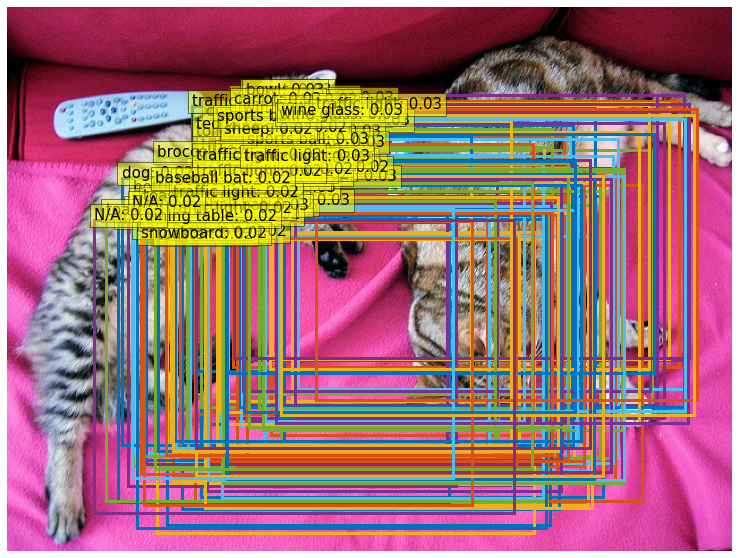

In [55]:
import matplotlib.pyplot as plt
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    
plot_results(im, scores, boxes)